In [1]:
# %pylab inline
%matplotlib qt4 
import matplotlib.pylab as plt
# matplotlib.rcParams['backend.qt4']='PySide'

In [2]:
# %pylab --no-import-all inline
%reload_ext autoreload
%autoreload 
import matplotlib
# import mpld3
# mpld3.enable_notebook()
# from IPython.core.debugger import Tracer; set_trace = Tracer()
import IPython
IPython.core.pylabtools.figsize(10, 8)
import cv2
import os
import seaborn as sns
import numpy as np
# import matplotlib.pylab as plt
import matplotutils
import pickle
import parameters
import imagesequencevideo
import subprocess
from joblib import Memory
import math
from numpy.lib.recfunctions import merge_arrays, append_fields
# from bokeh import mpl
# from bokeh.plotting import output_file, show, figure
from scipy import stats
from collections import OrderedDict
import itertools
import datetime
from tabulate import tabulate
from IPython.display import HTML, display
from sklearn import linear_model

In [476]:
experiment_root = '/home/matej/prace/sport_tracking/git/experiments/2016-08-22_subframe_synchronization/'  # len: match start + 600s
# experiment_root = '/home/matej/prace/sport_tracking/git/experiments/2016-09-17_subframe_mobile_seq/'
features_file = os.path.join(experiment_root, 'out/flashes2d_luminance_median.pkl')
paper_figures_dir = '/home/matej/Private/Dropbox/prace/publikace/2017 wacv/figures'
# memory = Memory(cachedir=experiment_root, verbose=0)
memory = Memory(cachedir='.', verbose=0)
all_cameras = [0, 1, 2, 3, 4]
cameras = [1, 2, 3, 4]

In [4]:
publish = True

if publish:
    fig_width_in = 4 # 2.953 # real column width -> too thick lines, font size probably also too big
    fig_height_in = fig_width_in * 0.7
       
    sns.set_style('ticks')  # or 'ticks'
    sns.set_context("paper")
    # sns.set(font='times')
    # plt.style.use(['seaborn-white', 'seaborn-paper'])
    sns.set_palette(sns.color_palette('muted')) # sns.cubehelix_palette())
    sns.set_color_codes()
    
    params = {
    #    'axes.labelsize': 9,
    #    'font.size': 9,
    #    'legend.fontsize': 9,
    #    'xtick.labelsize': 9,
    #    'ytick.labelsize': 9,
    #    'text.usetex': False,
        'figure.figsize': [fig_width_in, fig_height_in],
        'figure.dpi' : 80,
        'text.usetex': False,
        'font.family': 'serif',
        'savefig.dpi' : 300,
       }
    plt.rcParams.update(params)
    
    # # fig.set_size_inches(6, 3)
    # plt.tight_layout()
else:
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    params = {
    #    'axes.labelsize': 9,
    #    'font.size': 9,
    #    'legend.fontsize': 9,
    #    'xtick.labelsize': 9,
    #    'ytick.labelsize': 9,
    #    'text.usetex': False,
    #    'figure.figsize': [fig_width_in, fig_height_in],
        'figure.dpi' : 80,
        'text.usetex': False,
    #    'font.family': 'serif',
        'savefig.dpi' : 300,
       }
    plt.rcParams.update(params)    
    
    
# plt.rcParams

In [5]:
@memory.cache
def get_timestamps_ms(video_file, duration_mmss='01:00'):
    ffprobe_cmd = 'ffprobe -select_streams v -show_frames -show_entries ' \
        'frame=best_effort_timestamp_time,pkt_pts_time,coded_picture_number %s -of csv ' \
        '-read_intervals %%%s' % (video_file, duration_mmss)
    ffprobe_csv = subprocess.check_output(ffprobe_cmd.split()).decode('utf8')
    ffprobe_timestamps = np.recfromcsv(ffprobe_csv.split('\n'), usecols=(1,2,3), 
                                       names=('best_effort_timestamp_time', 'pkt_pts_time', 'coded_picture_number'))
    ffprobe_timestamps_ms = ffprobe_timestamps['best_effort_timestamp_time'] * 1000.
    return ffprobe_timestamps_ms

# 1.mp4:
# frame,134.716000,134.716000,3349
# frame,134.756000,134.756000,3350
# frame,134.796000,134.796000,3351
# frame,134.836000,134.836000,3352
# frame,134.876000,134.876000,3353

In [6]:
@memory.cache
def get_timestamps_ms_(video_file, duration_mmss='01:00'):
    ffprobe_cmd = 'ffprobe -select_streams v -show_frames -show_entries ' \
        'frame=best_effort_timestamp_time,pkt_pts_time,coded_picture_number %s -of csv ' \
        '-read_intervals %%%s' % (video_file, duration_mmss)
    ffprobe_csv = subprocess.check_output(ffprobe_cmd.split()).decode('utf8')
    ffprobe_timestamps = np.recfromcsv(ffprobe_csv.split('\n'), usecols=(1,2,3), 
                                       names=('best_effort_timestamp_time', 'pkt_pts_time', 'coded_picture_number'))
    ffprobe_timestamps_ms = ffprobe_timestamps['best_effort_timestamp_time'] * 1000.
    return ffprobe_timestamps_ms

In [7]:
# load features
with open(features_file, 'rb') as fr:
    features = pickle.load(fr)
    features_start = pickle.load(fr)

In [8]:
# load image sequences
p = parameters.Parameters(os.path.join(experiment_root, 'parameters.yaml'))
data_root = '../data/ihwc2015'
p.c['data_root'] = data_root
# p.c['data_root'] = '../data/synchronization_mobile'
del p.c['background_subtraction']['masks']
images = p.get_image_sequence()
assert isinstance(images, imagesequencevideo.ImageSequenceVideo)  # we need raw video, not synchronized sequences

In [9]:
images_dimensions = {}
for cam in p.c['cameras']:
    img = images.get_next_image(cam)
    images_dimensions[cam] = img.shape   

In [10]:
# [0, top] and [bottom, maxy] are obsolete regions (including top and bottom)
obsolete_regions = {cam: {'top': 28 , 'bottom': images_dimensions[cam][0] - 1} for cam in cameras}
obsolete_regions

{1: {'bottom': 2159, 'top': 28},
 2: {'bottom': 2159, 'top': 28},
 3: {'bottom': 719, 'top': 28},
 4: {'bottom': 719, 'top': 28}}

In [11]:
ms_per_frame = {0: 240, 1:40, 2:40, 3:40, 4:40}

In [12]:
features_len_minutes = [features[cam].shape[1] * ms_per_frame[cam] / 1000. / 60. for cam in all_cameras]
print 'apprixamated features_len_minutes ' + str(features_len_minutes)

apprixamated features_len_minutes [11.988, 9.93, 9.93, 8.346666666666668, 8.442666666666666]


In [ ]:
# plot possibly incorrect frames due to VideoCaptureAS seeking, see test_videosequence_seek.py
bad_frames = {2: np.array([4285, 4287, 4288, 4289]) - features_start[2]}
plt.plot(features[2][:, bad_frames[2]])

In [ ]:
from flashsynchronization import extract_features, compute_luminance_median

@memory.cache
def batch_extract_features(params, sync=None):
    images = p.get_image_sequence()
    # sync=None, match_start=None, sequence_length_sec=None:
    for cam in p.c['cameras']:
        print cam
        if sync:
            start = np.searchsorted(sync.get_timings()[cam], match_start)
            end = np.searchsorted(sync.get_timings()[cam], match_start + np.timedelta64(sequence_length_sec, 's'))
        else:
            start = 0
            end = -1
        features_start[cam] = start
        features[cam] = extract_features(images, compute_luminance_median, cam, start, end, dtype=np.uint8)
    return features, features_start
    
features, features_start = batch_extract_features(p) # images, p.c['cameras'])
# sync, np.datetime64('1900-01-01T' + p.c['match_start']), 600)

In [ ]:
if not os.path.exists(features_file):
    with open(features_file, 'wb') as fw:
        pickle.dump(features, fw)
        pickle.dump(features_start, fw)

## Event Detection

In [13]:
def get_events(features2d, hidden_scanlines=0, diffmax_peak_thresh=20):
# features2d = features[1]
# hidden_scanlines=0
# diffmax_peak_thresh=20
    diff = np.diff(features2d.astype(float), axis=1)
    n_scanlines = features2d.shape[0] + hidden_scanlines
    diff_max = np.max(diff, axis=0)
    idx = np.nonzero(diff_max > diffmax_peak_thresh)[0] + 1


    events = np.zeros(len(idx), dtype=[('frame', int),('start', float), ('end', float), ('position', float)])
    for i, frame in enumerate(idx):
        profile = diff[:, frame - 1]
        middle, start, end = ramp_detection(profile, difference=4)
        events[i] = (frame, start, end, frame + start / float(n_scanlines))        
    return events   

In [14]:
# artefact position detection
def ramp_detection(profile, difference=4):    
    max_pos = np.argmax(profile)
    try:
        start = np.flatnonzero(profile[:max_pos] > difference)[0]
        end = max_pos + np.flatnonzero(profile[max_pos:] > difference)[-1]
        middle = (start + end) / 2.
    except IndexError:
        start = np.nan
        end = np.nan
        middle = np.nan
    return middle, start, end

In [15]:
events = {cam: get_events(features[cam]) for cam in cameras}

In [16]:
override_good = {0: [], 1: [248, 4314, 9049], 2: [2088, 3605, 13418], 3: [4212,], 4: []}  # force to stay
override_start = {0: [], 1: [(9049, 983), ], 2: [], 3: [(4212, 633), ], 4: []}  # force to stay and fix start
override_bad = {0: [], 1: [], 2: [11475,], 3: [], 4: []}  # force to filter out

# cam = 2
# frame = 11475
# f2d = np.diff(features[cam].astype(float), axis=1)
# plot_frame_with_profile(cam, frame, features, diff2d=f2d)

In [17]:
# filter out wrong detections
events = {}
for cam in cameras:
    cam_events = get_events(features[cam])
    mask_not_trimmed = (cam_events['start'] > obsolete_regions[cam]['top']) & (cam_events['end'] < obsolete_regions[cam]['bottom']) 
    event_length_px = np.median(cam_events[mask_not_trimmed]['end'] - cam_events[mask_not_trimmed]['start'])
    override_bad_mask = np.any([cam_events['frame'] == frame for frame in override_bad[cam]], axis=0)
    mask_bad = (~(cam_events['end'] == obsolete_regions[cam]['bottom']) & 
                ((cam_events['end'] - cam_events['start']) < event_length_px * 0.9)) | \
               ((cam_events['end'] - cam_events['start']) > event_length_px * 1.1)  | \
                (cam_events['start'] <= obsolete_regions[cam]['top']) | \
                override_bad_mask
            
    override_good_mask = np.any([cam_events['frame'] == frame for frame in override_good[cam]], axis=0)
    events[cam] = cam_events[~mask_bad | override_good_mask]
    for frame, start in override_start[cam]:
        events[cam][np.where(events[cam]['frame'] == frame)[0][0]]['start'] = start

In [497]:
t = [[cam, len(events[cam])] for cam in cameras]
header = ['camera', 'flashes']
print tabulate(t, header, tablefmt='latex')

\begin{tabular}{rr}
\hline
   camera &   flashes \\
\hline
        1 &        43 \\
        2 &        40 \\
        3 &        30 \\
        4 &        34 \\
\hline
\end{tabular}


In [18]:
from synchronization import MultipleVideoSynchronization
sync = MultipleVideoSynchronization()
use_ocr = False
if use_ocr:
    ocred_timings = 'video/usa_rus/frame_timings.pkl'
    sync.load(os.path.join(p.c['data_root'], ocred_timings))
else:
    sync.frame_timings = {cam: get_timestamps_ms(os.path.join(data_root, p.c['video_sequences']) % cam, '20:00') 
                          for cam in all_cameras}
    # frame_timings_min_len = min([len(ft) for ft in sync.frame_timings.values()])
    # sync.frame_timings = {cam: sync.frame_timings[cam][:frame_timings_min_len] for cam in all_cameras}

In [19]:
# add events timing to timed_events
timed_events = {}
for cam in cameras:
    timings_n = len(sync.get_timings()[cam])
    have_timings = (features_start[cam] + events[cam]['frame']) < timings_n    
    timings = sync.get_timings()[cam][features_start[cam] + events[cam][have_timings]['frame']]
     # = merge_arrays((event_selection[cam], ().astype(dtype=[('timing', 'timedelta64[ms]')])))
    timed_events[cam] = append_fields(events[cam][have_timings], 'timing', 
                                      timings, 
                                      usemask=False)

In [20]:
# # show event frames
# cam
# idx = 3
# for cam, idx in menumerate(cameras):
#     plt.figure()
#     print int(event_pairs[i][idx, 0])
#     plt.imshow(images.get_image(features_start[cam] + int(event_pairs[i][idx, 0]), cam))
#     plt.grid(False)

In [758]:
cam = 1
partial_events_start = events[cam][events[cam]['start'] <= obsolete_regions[cam]['top']]['frame']
partial_events_end = {cam: events[cam][events[cam]['end'] >= obsolete_regions[cam]['bottom']]['frame']

SyntaxError: invalid syntax (<ipython-input-758-1590c61aa795>, line 3)

In [ ]:
# TODO: flash event splited in two frame
# cam = 2
# frame = 2183
# plt.imshow(images.get_image(features_start[cam] + 11474, 2) - images.get_image(features_start[cam] + 11475, cam))

## Single Stream Analysis

In [21]:
cam = 2

In [22]:
# compute 2d diff, 1d max features and artefact locations
f2d = np.diff(features[cam].astype(float), axis=1)
f1d = np.max(f2d, axis=0)
diff_thresh = 20
events_idx = np.nonzero(f1d > diff_thresh)[0] + 1

In [23]:
# plot max diff and peak detection (max (ax=0) diff (ax=1) median (ax=1) luminance)
limit_n_frames_bellow = 1500 # len(f1d) # 1000
f1d_limited = f1d[:limit_n_frames_bellow]
fig = plt.figure()

plt.plot(f1d_limited)
events_idx_ = events_idx[events_idx < limit_n_frames_bellow] - 1
plt.plot(events_idx_, len(events_idx_) * [max(f1d_limited) * 1.1], 'ro', label='detected\nevents')
plt.hlines(diff_thresh, 0, limit_n_frames_bellow,
           colors='r', linestyles='dotted', label='detection threshold')
if not publish:
    plt.title('Flash Artefact Feature Based on Line-wise Median of Luminance Channel')
plt.xlabel('frame number')
plt.ylabel('maximum of median line intensity')
plt.ylim(ymax=plt.ylim()[1] * 1.3) 
legend = plt.legend(loc='upper right', frameon=True)
frame = legend.get_frame()
frame.set_color('white')
sns.despine(fig)
if publish:
    plt.tight_layout()
    # fig.set_size_inches(column_width_in, column_width_in)
    plt.savefig(os.path.join(paper_figures_dir, 'feature1d_with_detections_cam%d.pdf' % cam))
    plt.close()

## Single Event Analysis

In [24]:
# select event
cam = 1
f2d = np.diff(features[cam].astype(float), axis=1)
frame = events_idx[0]

In [25]:
# plot flash image with corresponding profiles
# publish = True
# # plt.style.use('default')
# sns.set_style('white')

def plot_frame_with_profile(cam, frame, features, diff2d, start=None, end=None, filename=None):
    fig = plt.figure()
    plt.axis('tight')
    if publish:
        fig.set_size_inches(fig_width_in * 2, fig_height_in * 2 * 0.6, forward=True)
    gs = matplotlib.gridspec.GridSpec(1, 3, width_ratios=[7, 1, 1])
    if (start is None) or (end is None):
        __, start_, end_ = ramp_detection(diff2d[:, frame - 1])
    if start is None:
        start = start_
    if end is None:
        end = end_

    ax1 = plt.subplot(gs[0])
    img = images.get_image(features_start[cam] + frame, cam)
    height = img.shape[0]
    ax1.imshow(img)
    plt.title('frame $I_n$')
    plt.grid(False)
    plt.axis('off')
    #plt.tight_layout(0)
    if not np.isnan(start):
        plt.hlines([start, end], plt.xlim()[0], plt.xlim()[1], 'r', linestyles='dotted')

    ax = plt.subplot(gs[1], sharey=ax1)
    plt.title('median line\nintensity')
    # plt.plot(features[cam][:, frame] / features[cam][:, frame - 1].astype(float), range(height), label='divison')
    plt.plot(features[cam][:, frame], range(height), label='$\mathrm{I}_n$')
    plt.plot(features[cam][:, frame - 1], range(height), label='$\mathrm{I}_{n-1}$')
    if not np.isnan(start):
        plt.hlines([start, end], plt.xlim()[0], plt.xlim()[1], 'r', linestyles='dotted')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.spines['left'].set_position('zero')
    sns.despine(ax=ax)
    legend = plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
#     frame = legend.get_frame()
#     frame.set_color('white')

    ax = plt.subplot(gs[2], sharey=ax1)
    plt.title('median line\nintensity\ndifference')
    plt.plot(diff2d[:, frame - 1], range(height), label='$\mathrm{I}_n - \mathrm{I}_{n-1}$')
    plt.plot(diff2d[:, frame - 2], range(height), label='$\mathrm{I}_{n-1} - \mathrm{I}_{n-2}$')
    if not np.isnan(start):
        plt.hlines([start, end], plt.xlim()[0], plt.xlim()[1], 'r', linestyles='dotted')
    ax.axes.xaxis.set_ticklabels([])
    ax.spines['left'].set_position('zero')
    ax.axes.yaxis.set_ticklabels([])
    sns.despine(ax=ax)    
    # plt.xlim(xmax=80)  # plt.xlim()[1] * 1.5
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])    
    ax.legend(loc='upper left', bbox_to_anchor=(0.2, 1))
    # legend = plt
#     frame = legend.get_frame()
#     frame.set_color('white')

    plt.tight_layout(0, rect=(0, 0, 0.95, 1))
    plt.autoscale(tight=True)

    if publish:
        if filename is None:
            filename = 'flash_with_profiles_c%d_f%d.jpg' % (cam, frame)
        plt.savefig(os.path.join(paper_figures_dir, filename))
    return fig


In [26]:
cam = 2
frame = 8295
f2d = np.diff(features[cam].astype(float), axis=1)
_ = plot_frame_with_profile(cam, frame, features, diff2d=f2d, filename='flash_with_profiles_c%d_f%d.pdf' % (cam, frame))

In [27]:
# plot diff profile
cam = 2
frame = 740
f2d = np.diff(features[cam].astype(float), axis=1)
profile = f2d[:, frame - 1]
# middle, start, end = ramp_detection(profile)

fig = plt.figure()
fig.set_size_inches(fig_width_in, fig_height_in * 0.5)
if not publish:
    plt.title('median line intensity difference')
# profile = f2d[:, frame - 1]
# plt.plot(profile, range(len(profile)), label='flash frame')
plt.plot(range(len(profile)), f2d[:, frame - 1]) # , label='frame - 1')
plt.ylabel('pixel intensity')
plt.xlabel('row in pixels')
# plt.ylim(ymin=-5)
# plt.xlim(xmax=len(profile))
# plt.yticks([0, 10, 20, 30, 40])
sns.despine(fig, trim=True)
# ax.spines['bottom'].set_position('zero')
# plt.legend()
plt.tight_layout(0)

if publish:
    filename = 'diff_profile_c%d_f%d.pdf' % (cam, frame)
    plt.savefig(os.path.join(paper_figures_dir, filename))

# ramp_pos, ramp_start, ramp_end, ramp_middle_val = ramp_detection_middle_val(profile)
# plt.plot(ramp_middle_val, ramp_start, 'r.')
# plt.plot(ramp_middle_val, ramp_end, 'r.')

# output_file("diff_median_luminance.html", title="diff median luminance")
# fig = mpl.to_bokeh()
# import bokeh.models.tools
# fig.add_tools(bokeh.models.tools.ResizeTool())
# show(fig)

In [134]:
# plot diff for all frames with detected events
plt.figure()
f2d[f2d < 0] = 0
img = cv2.normalize(f2d, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=8)
plt.imshow(img.T, cmap='gray')  # warning: inline figure is too small to show 1 px wide artefacts
plt.grid(False)
plt.axis('tight')
plt.plot(events[cam][['start', 'end']].view((float, 2)), events[cam]['frame'] - 1, '.r')


## Batch Event Visualization

In [662]:
# plot flash images with corresponding profiles
plt.interactive(False)
for cam, cam_events in events.iteritems():
    diff2d = np.diff(features[cam].astype(float), axis=1)
    
    mask_not_trimmed = (cam_events['start'] > obsolete_regions[cam]['top']) & (cam_events['end'] < obsolete_regions[cam]['bottom']) 
    event_length_px = np.median(cam_events[mask_not_trimmed]['end'] - cam_events[mask_not_trimmed]['start'])
    mask_bad = (~(cam_events['end'] == obsolete_regions[cam]['bottom']) & 
                ((cam_events['end'] - cam_events['start']) < event_length_px * 0.9)) | \
               ((cam_events['end'] - cam_events['start']) > event_length_px * 1.1)  | \
                (cam_events['start'] <= obsolete_regions[cam]['top'])   
            
    for e in cam_events[~mask_bad]:
        fig = plot_frame_with_profile(cam, e['frame'], features, diff2d)
        plt.close(fig)
    for e in cam_events[mask_bad]:
        fig = plot_frame_with_profile(cam, e['frame'], features, diff2d,
                                      filename='batch/bad/flash_with_profiles_c%d_f%d.jpg' % (cam, e['frame']))
        plt.close(fig)
        
plt.interactive(True)

In [ ]:
plt.interactive(False)
for cam, cam_events in events.iteritems():
    diff2d = np.diff(features[cam].astype(float), axis=1)
plt.interactive(True)

In [ ]:
features[cam][:, cam_events[:, 0].astype(int)].shape

In [ ]:
plt.interactive(True)
plt.plot(xrange(720), features[cam][:, cam_events[:, 0].astype(int)])
plt.show()

In [ ]:
diff2d = np.diff(features[cam].astype(float), axis=1)
plt.plot(diff2d[:, cam_events[::5, 0].astype(int) - 1], xrange(720))

## Timing Statistics

In [138]:
[len(sync.frame_timings[cam]) for cam in all_cameras]

[5997, 29824, 29840, 25052, 25358]

In [139]:
features_start_minutes = [sync.frame_timings[cam][features_start[cam]] / 1000. / 60. for cam in all_cameras]
print np.array2string(np.array(features_start_minutes), precision=2)

[ 1.24  1.12  1.01  1.74  1.52]


In [30]:
# periodicity of non standard frame durations 
print np.diff(np.nonzero((np.diff(sync.frame_timings[0]) == 159))[0])
print np.diff(np.nonzero((np.diff(sync.frame_timings[2]) == 41))[0])

[ 20  12  20  12  20  12  19  65  12 116  12  20 128  12  52  12 116  32  44  20  12  19  32  13  20  63  33  12  20  12  20  12  64  20  32  12  20
  12  52  12  20  12  20  12  32  32  20  12  20  12  32  20  12  64  20  12  32  20  12  51  45  20  12  64  20  12  20  12  20  12  20  12  20  12
  20  12  84  12  32  32  31  20  13  32  20  12  20  12  84  12  20  12  52  12  20  32  12  20  12  20  12  20  12  20  12  20  12  20  44  20  12
  20  12  20  12  20  12  20  12  20  12  20  32 140  32  20  12  20  12  32  64  20  12  32  20  12  20  12  20  12  32  20  12  20  12  20  12  20
  12 180  12  32  32  32  20  12  20  64  32  12  20  44 116  12  20  12  64 148  12  20  64  12  20  12  20  12 128  52  12  20  76  84  12  20  12
  20  12  20  12  32  20  12  32  52  12  20  12  32  20  32  12  20  12  20 109  31  20  12  20  12  20  12  20  12  33]
[ 96  96  96  64  96  96  96  96  64  96  96  96  96  64  96  96 160  96  96  96  96  64  96  96  96  64 128  64  96  96  96  96  64 

In [152]:
# show timing visualizations
# TODO produce some summary visualization

for i, cam in enumerate([1]):  # all_cameras
    frame_timings = np.round(get_timestamps_ms(os.path.join(data_root, p.c['video_sequences']) % cam, '20:00'), 6)
    
    fig = plt.figure()
    diff_timing = np.diff(frame_timings)
    unique_diff_timing = np.unique(diff_timing)
    diff_mode, _ = stats.mode(diff_timing)
    
#     plt.hist(diff_timing, histtype='stepfilled', bins=unique_diff_timing, # range=(0.9 * np.median(diff_timing), 2.2 * np.median(diff_timing)), 
#              log=True, cumulative=True) # np.linspace(30, 90, 30)

#     sns.distplot(diff_timing, kde=False, bins=unique_diff_timing,
#                  hist_kws={'cumulative': True, 'histtype': 'stepfilled'}, 
#                  rug=False)
#     plt.xticks(np.arange(diff_mode, diff_timing.max(), diff_mode))
#     plt.title('Frame durations histogram (camera %d)' % cam)
#     plt.xlabel('event timing difference [ms]')
#     plt.ylabel('count')
#     if publish:
#         plt.savefig(os.path.join(paper_figures_dir, 'cam%d_durations_histogram.png' % cam))    

    plt.figure()
    val, count = np.unique(diff_timing, return_counts=True)
    sort_idx = np.argsort(count)[::-1]    
       
    header = ['duration in ms', 'count']
    table = np.vstack((val[sort_idx], count[sort_idx])).T
    display(HTML(tabulate(table, header, tablefmt='html')))
    break   
    
    print('cam %d: unique durations counts: %s' % (cam, str(count[sort_idx])))
    bars = plt.bar(np.arange(len(count)), count[sort_idx], log=True)
    plt.xticks(np.arange(len(count)) + 0.5, val[sort_idx], rotation='vertical') # np.round(val[sort_idx], 6)
    plt.title('Frame durations statistics (camera %d)' % cam)
    plt.xlabel('durations [ms]')
    plt.ylabel('count')
    plt.tight_layout()
    if publish:
        plt.savefig(os.path.join(paper_figures_dir, 'cam%d_frame_duration_statistics.png' % cam))
    

    mode_duration_ms, _ = stats.mode(diff_timing)
    mask_clean = (0.8 * mode_duration_ms < diff_timing) & (diff_timing  < 1.2 * mode_duration_ms)
    diff_timing_clean = diff_timing[np.nonzero(mask_clean)]
    duration_errors = diff_timing_clean - mode_duration_ms * np.ones(len(diff_timing_clean)) 
    

    plt.figure()
    plt.plot(duration_errors, '.')
    plt.title('Deviations from %0.2f ms frame duration (camera %d)' % (mode_duration_ms, cam))
    plt.xlabel('frame')
    plt.ylabel('deviation [ms]')
    plt.yticks(np.unique(duration_errors))
    plt.margins(y=0.05, x=0)
    if publish:
        plt.savefig(os.path.join(paper_figures_dir, 'cam%d_frame_duration_errors.png' % cam))
       
    plt.figure()
    __ = plt.hist(duration_errors[np.nonzero(duration_errors)])
    plt.title('Deviations from %0.2f ms frame duration (camera %d)' % (mode_duration_ms, cam))
    plt.xlabel('deviation [ms]')
    plt.ylabel('counts')    
    if publish:
        plt.savefig(os.path.join(paper_figures_dir, 'not used/cam%d_duration_errors_histogram.png' % cam))


duration in ms,count
40,29339
41,318
80,157
81,5
120,3
39,1


In [140]:
statistics = []
for i, cam in enumerate(all_cameras):
    frame_timings = np.round(get_timestamps_ms(os.path.join(data_root, p.c['video_sequences']) % cam, '20:00'), 6)
    diff_timing = np.diff(frame_timings)
    mode_duration_ms, _ = stats.mode(diff_timing)
    mask_clean = (0.8 * mode_duration_ms < diff_timing) & (diff_timing  < 1.2 * mode_duration_ms)
    diff_timing_clean = diff_timing[np.nonzero(mask_clean)]
    duration_errors = diff_timing_clean - mode_duration_ms * np.ones(len(diff_timing_clean))
    
    statistics.append(OrderedDict([
                       ('camera', cam), 
                       ('frames', len(frame_timings)), 
                       ('duration', datetime.timedelta(milliseconds=frame_timings[-1])),
                       ('mode [ms]', mode_duration_ms),
                       ('mode fps', 1000 / mode_duration_ms),
                       ('clean frames', np.count_nonzero(mask_clean)),
                       ('bad frames', len(diff_timing) - np.count_nonzero(mask_clean)),
                       ('bad frames [%]', (len(diff_timing) - np.count_nonzero(mask_clean)) / float(len(diff_timing)) * 100),                       
                       ('clean frames not accurate', np.count_nonzero(duration_errors)),
                       ('clean frames not accurate [%]', np.count_nonzero(duration_errors) / float(len(duration_errors)) * 100),
                       ('sum clean frames error [ms]', duration_errors.sum())
                      ]))
    
display(HTML(tabulate(statistics, headers='keys', tablefmt='html', floatfmt='0.2f')))
print """
- clean frames: duration close to duration mode
- bad frames: other frames, mainly dropped frames and other outliers
- clean frames not accurate: clean frames with duration other than mode
- clean frames not accurate [%]: out of clean frames
"""  

camera,frames,duration,mode [ms],mode fps,clean frames,bad frames,bad frames [%],clean frames not accurate,clean frames not accurate [%],sum clean frames error [ms]
0,5997,0:19:59.852000,240.00,4.17,2984,3012,50.23,174,5.83,-136.00
1,29824,0:19:59.962000,40.00,25.00,29658,165,0.55,319,1.08,317.00
2,29840,0:19:59.974000,40.00,25.00,29711,128,0.43,330,1.11,330.00
3,25052,0:19:59.927000,40.00,25.00,20861,4190,16.73,330,1.58,-16.00
4,25358,0:19:59.960000,40.00,25.00,21307,4050,15.97,299,1.40,38.00



- clean frames: duration close to duration mode
- bad frames: other frames, mainly dropped frames and other outliers
- clean frames not accurate: clean frames with duration other than mode
- clean frames not accurate [%]: out of clean frames



In [153]:
plt.close('all')

In [ ]:
mean_error_in_lines = np.mean(duration_errors) / mode_duration_ms * images_dimensions[cam][0]
std_error_in_lines = np.std(duration_errors) / mode_duration_ms * images_dimensions[cam][0]
print mean_error_in_lines, std_error_in_lines

## Synchronization

In [31]:
# manual event association
cameras = [1, 2, 3, 4]
event_selection_idx = {1: [0, 1], 2: [0, 1], 3: [0, 1], 4: [0, 1]}
# cameras = [1, 2]
# event_selection_idx = {1: [0, 1, 2, 3, 9], 2: [0, 1, 2, 3, 11]}
# cameras = [3, 4]
# event_selection_idx = {3: [0, 1, 3], 4: [0, 1, 2]}

In [32]:
synchronization_events_idx = {1: 0, 2: 0, 3: 0, 4: 0}

In [33]:
event_selection = {cam: timed_events[cam][idxs] for cam, idxs in event_selection_idx.iteritems()}

In [34]:
# show paired event frames side by side
def show_synchronized_frames(indices, cameras, events, publish=False):
    if publish:
        ydim = int(math.floor(math.sqrt(len(cameras))))
        xdim = int(math.ceil(len(cameras) / ydim))
        frame_str = ''
    for i, (idx, cam) in enumerate(zip(indices, cameras)):
        frame = events[cam][idx]['frame']
        if publish:
            plt.subplot(ydim, xdim, i + 1)
            frame_str += '_' + str(frame)
        else:
            plt.figure()
        plt.imshow(images.get_image(features_start[cam] + frame, cam)) 
        plt.grid(False)
        plt.axis('off')

    if publish:
        plt.tight_layout(pad=1)
        plt.savefig(os.path.join(paper_figures_dir, 'flashes%s.png' % frame_str))

In [ ]:
i = 4
show_synchronized_frames([event_selection_idx[cam][i] for cam in cameras], cameras, timed_events, publish=False)

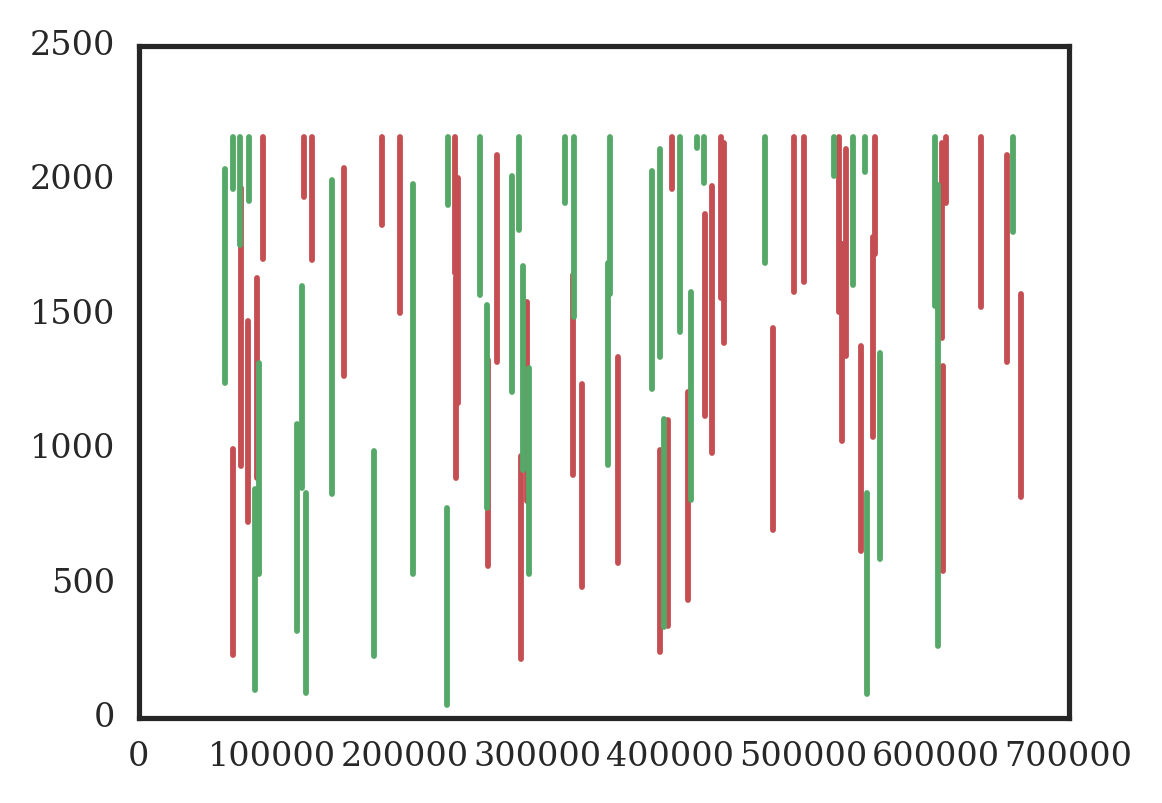

In [149]:
# visualize all events detected in 2 video streams
fig = plt.figure()

assert len(cameras) == 2
   
for cam, color in zip(cameras, ('r', 'g')):    
    plt.plot(np.tile(timed_events[cam]['timing'], (2, 1)), timed_events[cam][['start', 'end']].view((float, 2)).T, 
             '-' + color) # 
#     for i, event in enumerate(events[cam]):
#         if event['frame'] == -1:
#             continue
#         if publish:
#             s = '%0.2f' % event['frame']
#         else:
#             s = '%d: %0.2f' % (i, event['frame'])
#         plt.annotate(s, (event_timing[cam], event['start']), (0, -20), 
#                      textcoords='offset points', color=color)    
# plt.axis('tight')
# __ = plt.xlim(0, width)
# plt.imsave('diff_median.png', diff_img)
# matplotutils.save_figure_as_image('diff_median.png', fig)
if publish:
    plt.savefig(os.path.join(paper_figures_dir, 'diff_median_rg_cam%d%d.png' % tuple(cameras))) # , bbox_inches='tight') # , pad_inches=0
else:
    plt.title('composite diff image emphasizing flash events, cam %d - red, %d - green' % tuple(cameras))
    
fig

In [206]:
# def get_subframe_timing(events, timings, height):
#     frame_duration_ms = np.median(np.diff(timings))
#     subframe_ms = events['start'] / height * frame_duration_ms
#     return events['timing'] + subframe_ms

def get_subframe_timing(cam, events, event_idx=slice(None)):
    frame_duration_ms = np.median(np.diff(sync.get_timings()[cam]))
    height = images_dimensions[cam][0]
    subframe_ms = (height - events[cam][event_idx]['start']) / height * frame_duration_ms
    # events[cam][event_idx]['timing'] +
    return subframe_ms

# get_subframe_timing(timed_events[cameras[0]][event_pairs_idx[0]], sync.get_timings()[cameras[0]], height=images_dimensions[cameras[0]][0]) - \
# get_subframe_timing(timed_events[cameras[1]][event_pairs_idx[1]], sync.get_timings()[cameras[1]], height=images_dimensions[cameras[1]][0])

# get_subframe_timing(cameras[0], event_pairs_idx[0])
# get_subframe_timing(cameras[1], event_pairs_idx[1])

### Events Matching

In [41]:
timed_events_nan = {}
nan_event = np.array((-1, np.nan, np.nan, np.nan, np.nan), 
                     dtype=[('frame', int),('start', float), ('end', float), ('position', float), ('timing', float)])
for cam in cameras:
    timed_events_nan[cam] = np.append(timed_events[cam], nan_event)

In [500]:
# find close events
def match_events(timings, cameras, offsets, base_cam, close_events_thresh_ms=35):
    nan_val = np.nan
    timings_rel = {cam: timings[cam] - offsets[cam] for cam in cameras}
    
#     fig = plt.figure()
#     plt.eventplot([t for t in timings_rel.values()]) # , colors=['r', 'b']) # , 'r', 'b'])
#     sns.despine(fig)
    
    n_timings = {cam: len(timings[cam]) for cam in cameras}
    cam2idx = {cam: i for i, cam in enumerate(cameras)}
    for cam in cameras:
        assert np.all(np.diff(timings[cam]) > 0)
    position = {cam: 0 for cam in cameras}
    all_matched = []
    while position[base_cam] < n_timings[base_cam]:        
        matched = [nan_val] * len(cameras)
        matched[cam2idx[base_cam]] = position[base_cam]
        position[base_cam] += 1
        for cam in set(cameras) - set([base_cam]):
            while position[cam] < n_timings[cam] and \
                timings_rel[cam][position[cam]] < timings_rel[base_cam][matched[cam2idx[base_cam]]] - close_events_thresh_ms:
                single_event = [nan_val] * len(cameras)
                single_event[cam2idx[cam]] = position[cam]
                all_matched.append(single_event)          
                position[cam] += 1
            if position[cam] != n_timings[cam] and \
                timings_rel[cam][position[cam]] < timings_rel[base_cam][matched[cam2idx[base_cam]]] + close_events_thresh_ms:
                matched[cam2idx[cam]] = position[cam]
                position[cam] += 1
        all_matched.append(matched)
        
    for cam in set(cameras) - set([base_cam]):
        while position[cam] < n_timings[cam]:
            single_event = [nan_val] * len(cameras)
            single_event[cam2idx[cam]] = position[cam]
            all_matched.append(single_event)                
            position[cam] += 1

    return np.array(all_matched)
              

base_cam = 1
cameras = [1, 2, 3, 4]
matched = match_events({cam: timed_events[cam]['timing'] for cam in cameras}, cameras, 
             {cam: timed_events[cam][event_selection_idx[cam][0]]['timing'] for cam in cameras}, # timed_events[base_cam][event_selection_idx[base_cam][0]]['timing'] - 
             base_cam, close_events_thresh_ms=80)
mask_full_match = ~np.isnan(matched.sum(axis=1))

In [43]:
# visualize not synchronized events
fig = plt.figure()
timings = [timed_events[cam]['timing'] for cam in cameras]
plt.eventplot(timings, 
              colors=sns.color_palette(n_colors=len(cameras)),
              linelengths=0.95)
plt.yticks(np.arange(len(cameras)), cameras)
plt.ylabel('cameras')
max_timing = max([max(t) for t in timings])
plt.xticks(np.arange(0, max_timing, step=200000),
           (np.arange(0, max_timing, step=200000) / 1000).astype(int))
plt.xlabel('time in seconds')
plt.tight_layout(0)
sns.despine(fig) # , left=True)
if publish:
    plt.savefig(os.path.join(paper_figures_dir, 'events_' + '_'.join([str(c) for c in cameras]) + '.pdf'))

In [44]:
mask_full_match

array([ True,  True, False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True, False, False, False, False, False,  True, False, False, False, False, False,  True, False, False, False, False,
        True,  True, False, False,  True], dtype=bool)

In [45]:
# visualize aligned events
offsets = {cam: timed_events[cam][event_selection_idx[cam][0]]['timing'] for cam in cameras}
timings_rel = {cam: timed_events[cam]['timing'] - offsets[cam] for cam in cameras}

# subframe = {cam: get_subframe_timing(cam, timed_events) for cam in cameras}
# subframe_rel = {cam: timings_rel[cam] + subframe[cam] for cam in cameras}
plt.eventplot([t for t in timings_rel.values()],
              colors=sns.color_palette(n_colors=len(cameras)),
              linelengths=0.95)
plt.yticks(np.arange(len(cameras)), cameras)
plt.ylabel('cameras')
max_timing = max([max(timings_rel[cam]) for cam in cameras])
plt.xticks(np.arange(0, max_timing, step=200000),
           (np.arange(0, max_timing, step=200000) / 1000).astype(int))
plt.xlabel('time in seconds')
plt.tight_layout(0)
sns.despine(fig) # , left=True)

In [46]:
# matched_nan = matched.astype(float)
# matched_nan[matched_nan == -1] = np.nan
# mask_full_match = ~np.isnan(matched_nan.sum(axis=1))
# base_cam_idx = 0
# for idx, cam in enumerate(cameras):
#     print timed_events_nan[cam][matched[:, idx]][mask_full_match]['timing'] - timed_events_nan[base_cam][matched[:, base_cam_idx]][mask_full_match]['timing']

In [47]:
matched_events = {}
for idx, cam in enumerate(cameras):
    matched_events[cam] = timed_events[cam][matched[mask_full_match].astype(int)[:, idx]]

In [48]:
def get_matched_events(cameras, events, event_selection_idx, base_cam):
    matched = match_events({cam: events[cam]['timing'] for cam in cameras}, cameras, 
                 {cam: events[cam][event_selection_idx[cam][0]]['timing'] for cam in cameras}, 
                 base_cam, close_events_thresh_ms=80)
    mask_full_match = ~np.isnan(matched.sum(axis=1))
    matched_events = {}
    for idx, cam in enumerate(cameras):
        matched_events[cam] = events[cam][matched[mask_full_match].astype(int)[:, idx]]
    return matched_events

In [49]:
matched_events_ok = {cam: matched_events[cam] for cam in cameras}
matched_events_ok

{1: array([(96, 233.0, 1000.0, 96.10787037037036, 70779.0), (248, 936.0, 1969.0, 248.43333333333334, 76860.0),
        (546, 890.0, 1637.0, 546.4120370370371, 88943.0), (6466, 902.0, 1645.0, 6466.417592592593, 327168.0),
        (6631, 486.0, 1240.0, 6631.225, 333849.0), (8313, 1965.0, 2159.0, 8313.909722222223, 401427.0),
        (8609, 438.0, 1210.0, 8609.202777777778, 413471.0), (10182, 697.0, 1450.0, 10182.322685185185, 477368.0),
        (11827, 621.0, 1383.0, 11827.2875, 543546.0), (13370, 547.0, 1307.0, 13370.253240740742, 605602.0),
        (13417, 1916.0, 2159.0, 13417.887037037037, 607523.0), (14834, 821.0, 1575.0, 14834.380092592593, 664418.0)], 
       dtype=[('frame', '<i8'), ('start', '<f8'), ('end', '<f8'), ('position', '<f8'), ('timing', '<f8')]),
 2: array([(96, 1246.0, 2043.0, 96.57685185185186, 64697.0), (247, 1968.0, 2159.0, 247.9111111111111, 70779.0),
        (547, 1922.0, 2159.0, 547.8898148148148, 82862.0), (6446, 1916.0, 2159.0, 6446.887037037037, 321089.0),
  

In [204]:
# visualization: stream events synchronization
def multitple_streams_events_visualization(cameras, offsets, events, start_s=0, duration_s=200):
    camera_events = []
    event_linestyles = []
    for cam in cameras:
        camera_events.extend([
            # sync.get_timings()[cam] - offsets[cam],
            events[cam]['timing'] - offsets[cam],
            events[cam]['timing'] - offsets[cam] + get_subframe_timing(cam, events)
            ])
        event_linestyles.extend([
                'dashed',
                'solid'
            ])

    camera_events_short = []
    for ce in camera_events:
        event_range = xrange(*np.searchsorted(ce, [start_s * 1000, (start_s + duration_s) * 1000]))
        camera_events_short.append(ce[event_range]) #  / 1000. / 60.)    

    palettes = {1: 'Blues', 2: 'Reds', 3: 'Blues', 4: 'Reds'}
    n_events_per_cam = len(camera_events_short) / len(cameras)
    event_colors = []
    event_lineoffsets = []
    for i, cam in enumerate(cameras):
        event_colors.extend(sns.color_palette(palettes[cam], n_events_per_cam))
        event_lineoffsets.extend([i] * n_events_per_cam)       
        

    fig = plt.figure()
    plots = plt.eventplot(camera_events_short, 
                  linelengths=1, 
                  lineoffsets=event_lineoffsets, 
                  colors=event_colors,
                  linestyles=event_linestyles) #, label=[1, 1, 1, 1, 1, 1])
    plt.xlabel('time in minutes')
    # plt.legend((plots[0], plots[3]), ['cam %d' % cam for cam in cameras])     # probably not possible, plots[] are EventCollection(LineCollection) 
                                                                                # where no Artists are available for legend to bind to
    fig.get_axes()[0].get_yaxis().set_visible(False)
    plt.tight_layout(pad=1)
    
# multitple_streams_events_visualization(cameras, frame_offsets, duration_s=1300)

In [207]:
# timed_events[cam][event_pairs_idx[cam]]
subframe = {cam: get_subframe_timing(cam, matched_events_ok) for cam in cameras}

offsets = {cam: timed_events[cam][event_selection_idx[cam][0]]['timing'] - 
                subframe[cam][event_selection_idx[cam][0]] for cam in cameras}
subframe_timing = np.vstack([matched_events_ok[cam]['timing'] - subframe[cam] for cam in cameras])
cam234_offsets = np.median(subframe_timing[1:] - subframe_timing[0], axis=1)
offsets_subframe = {1: 0, 2: cam234_offsets[0], 3: cam234_offsets[1], 4: cam234_offsets[2]}
plots = multitple_streams_events_visualization(cameras, 
                                               offsets_subframe, 
                                               matched_events_ok,
                                               duration_s=1300)

In [50]:
(subframe_timing[1:] - subframe_timing[0]).std(axis=1) * lines_per_ms[1:]

NameError: name 'subframe_timing' is not defined

In [274]:
(subframe_timing[1:] - subframe_timing[0]) - np.median(subframe_timing[1:] - subframe_timing[0], axis=1).reshape((-1, 1))

array([[ -3.35,  -2.  ,  -2.  ,  -0.33,   0.5 ,  -8.22,   0.37,   0.33,   1.2 ,   2.13,  -6.65,   2.13],
       [ -0.05,   3.32,   4.56,   0.12,   0.05,  -3.9 ,  -5.73,   0.47,  -7.51,   0.36, -12.44,  -7.99],
       [  1.08,   3.12,   4.86,  -1.47,  -1.66,  -6.05,   5.79,  -1.79,   4.4 ,  -3.56,  -1.08,   2.31]])

In [208]:
lines_per_ms = np.array([images_dimensions[cam][0] for cam in cameras]) / 40.

In [209]:
fig = plt.figure()
ax = fig.gca()
colors = sns.color_palette(n_colors=3)
for t, c in zip(subframe_timing[1:] - subframe_timing[0],
                colors):
    ax_ = ax.twinx()
    ax_.plot(t, color=c)

### Time vs px Diffs Evaluation

In [210]:
timing_ok = np.vstack([matched_events_ok[cam]['timing'] for cam in cameras])
start_ok = np.vstack([matched_events_ok[cam]['start'] for cam in cameras])
timing_diff12 = timing_ok[0] - timing_ok[1]
start_diff12 = start_ok[0] - start_ok[1]
timing_diff34 = timing_ok[2] - timing_ok[3]
start_diff34 = start_ok[2] - start_ok[3]

timing_diff13 = timing_ok[0] - timing_ok[2]
start_diff13 = start_ok[0] - start_ok[2]

timing_diff14 = timing_ok[0] - timing_ok[2]
start_diff14 = start_ok[0] - start_ok[2]

In [211]:
fig = plt.figure()
ax = fig.gca()
colors = sns.color_palette(n_colors=3)
for t, c in zip([timing_diff14, -start_diff14],
                colors):
    ax_ = ax.twinx()
    ax_.plot(t, color=c)

### Evaluation

In [ ]:
offsets = {cam: timed_events[cam][synchronization_events_idx[cam]]['timing'] for cam in cameras}
pairs = find_event_pairs(timed_events, cameras, offsets)
synchronization_errors = \
(timed_events[cameras[0]][pairs[cameras[0]]]['timing'] - offsets[cameras[0]]) - \
(timed_events[cameras[1]][pairs[cameras[1]]]['timing'] - offsets[cameras[1]])

In [475]:
def events_table_histogram(events, base_cam):
    t = []
    headers = []
    for cam, e in events.iteritems():        
        t.extend([
            e['timing'],
            e['start'],
            e['timing'] - get_subframe_timing(cam, events),
            # e['end']                
            ])
        headers.extend([
            'cam%d [ms]' % cam,
            'cam%d start [px]' % cam,
            'cam%d sub [ms]' % cam,            
            # 'cam%d end [px]' % cam
            ])
        
    for cam in set(events.keys()) - set([base_cam]):
        X = events[base_cam]['timing'].reshape((-1, 1))
        y = events[base_cam]['start'] - events[cam]['start']        
        resid, model = flash_start_linear_fit(X, y)
        resid[~model.inlier_mask_] = np.nan
        t.extend([
                events[base_cam]['timing'] - events[cam]['timing'],
                events[base_cam]['start'] - events[cam]['start'],
                (events[base_cam]['timing'] - get_subframe_timing(base_cam, events)) -
                (events[cam]['timing'] - get_subframe_timing(cam, events)),
                resid,
            ])
        headers.extend([
                'diff %d %d [ms]' % (base_cam, cam),
                'diff start %d %d [px]' % (base_cam, cam),
                'diff sub %d %d [ms]' % (base_cam, cam),
                'diff start linfit resid %d %d [px]' % (base_cam, cam),
            ])
        
    table = np.vstack(t).T
    html_table = HTML(tabulate(table, headers=headers, tablefmt='html'))

#     plt.figure()
#     __ = plt.hist(t[:, 5], 100)
#     plt.title('Synchronized events lead-in line difference')
#     plt.xlabel('difference [px]')
#     plt.ylabel('count')
    return html_table, table, headers
    
html_table, table, headers = events_table_histogram(matched_events_ok, 3)
#     {cam: matched_events[cam][['timing', 'start', 'end']] for cam in cameras}, 1)
html_table

cam1 [ms],cam1 start [px],cam1 sub [ms],cam2 [ms],cam2 start [px],cam2 sub [ms],cam3 [ms],cam3 start [px],cam3 sub [ms],cam4 [ms],cam4 start [px],cam4 sub [ms],diff 3 1 [ms],diff start 3 1 [px],diff sub 3 1 [ms],diff start linfit resid 3 1 [px],diff 3 2 [ms],diff start 3 2 [px],diff sub 3 2 [ms],diff start linfit resid 3 2 [px],diff 3 4 [ms],diff start 3 4 [px],diff sub 3 4 [ms],diff start linfit resid 3 4 [px]
70779,233,70743.3,64697,1246,64680.1,108273,238,108246,94637,81,94601.5,37494,5,37502.9,-170.281,43576,-1008,43566.1,-218.736,13636,157,13644.7,1.37423
76860,936,76837.3,70779,1968,70775.4,114353,551,114344,100716,388,100698,37493,-385,37506.3,215.997,43574,-1417,43568.2,186.882,13637,163,13646.1,-0.537212
88943,890,88919.5,82862,1922,82857.6,126432,630,126427,112796,458,112781,37489,-260,37507.5,83.6002,43570,-1292,43569.4,55.1638,13636,172,13645.6,-1.41457
327168,902,327145,321089,1916,321084,364658,536,364648,351029,204,351000,37490,-366,37503.1,43.7278,43569,-1380,43563.3,10.6604,13629,332,13647.4,-1.21716
333849,486,333818,327771,1491,327759,371337,432,371321,357708,98,357673,37488,-54,37503,-272.362,43566,-1059,43562.4,nan,13629,334,13647.6,1.2742
401427,1965,401423,395389,339,395355,438933,530,438922,425306,152,425274,37506,-1435,37499.1,nan,43544,191,43567.2,nan,13627,378,13648,2.7298
413471,438,413439,407393,1436,407380,450973,60,450936,437306,648,437302,37502,-378,37497.2,2.87469,43580,-1376,43556.7,-41.3488,13667,-588,13634.3,nan
477368,697,477341,471290,1693,471281,514848,654,514844,501224,220,501196,37480,-43,37503.4,nan,43558,-1039,43563,nan,13624,434,13648.1,-2.22042
543546,621,543518,537469,1610,537459,581044,161,581013,567382,666,567379,37498,-460,37495.4,5.22859,43575,-1449,43554.1,-40.6955,13662,-505,13633.9,nan
605602,547,605572,599526,1532,599514,643081,620,643075,629460,102,629426,37479,73,37503.3,nan,43555,-912,43561.1,nan,13621,518,13649.8,0.0111233


In [223]:
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(matched_events_ok[1]['timing'] - matched_events_ok[2]['timing'], 'r', label='diff timing')
ax2.plot(matched_events_ok[1]['start'] - matched_events_ok[2]['start'], 'b', label='diff start')
plt.legend()
np.corrcoef()

In [51]:
def flash_start_linear_fit(X, y=None):
    model = linear_model.LinearRegression()
    model.fit(X.reshape((-1, 1)), y)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(X, y)
    residuals = model_ransac.predict(X).flatten() - y
    return residuals, model_ransac    

In [52]:
def fit_timing_plus_start(cam1, cam2, events):
    model = linear_model.LinearRegression()
    n = len(events[cam1])
    X = np.vstack((
        events[cam1]['start'],
        -events[cam2]['start'],
        )).T
    y = events[cam2]['timing'] - events[cam1]['timing']
    model.fit(X, y)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(X, y)  
    return model_ransac

In [474]:
for i, j in itertools.combinations(cameras, 2): # [[1, 2]]: # itertools.combinations(cameras, 2):   
    events_ij = get_matched_events([i, j], timed_events, event_selection_idx, min(i, j), obsolete_regions)
    model = fit_timing_plus_start(i, j, matched_events_ok)
    coef = np.concatenate((model.estimator_.intercept_, model.estimator_.coef_[0]))
    delay = (matched_events_ok[i]['timing'] + coef[1] * matched_events_ok[i]['start']) - \
            (matched_events_ok[j]['timing'] + coef[2] * matched_events_ok[j]['start']) + \
            coef[0]
    #print delay[model.inlier_mask_]
    print i, j, delay[model.inlier_mask_].std(), coef, np.count_nonzero(~model.inlier_mask_)
    # print delay[model.inlier_mask_]
    plt.plot(delay[model.inlier_mask_], label='%d %d (std: %f)' % (i, j, delay[model.inlier_mask_].std()))
    
plt.legend()

#     print delay 
# (delay + model.intercept_).std()    
# print model_ransac.inlier_mask_
# print model.coef_`
# print model_ransac.estimator_.coef_
# print model.intercept_
# print model_ransac.estimator_.intercept_

1 2 0.825212576434 [-6055.8827775533     0.0126226455     0.018470428 ] 2
1 3 2.02791270446 [ 37496.8054488397      0.0140761495      0.0363956651] 0
1 4 1.2819488587 [ 23856.543286827       0.0146998499      0.0440536733] 1
2 3 2.96377051776 [ 43554.3023508892      0.0171491738      0.0335837903] 1
2 4 3.03446240005 [ 29917.5509841792      0.0170837489      0.0462089811] 0
3 4 0.643085265206 [-13641.9766861652      0.0398184755      0.0406977203] 0


In [468]:
cam = 4
np.set_printoptions(precision=10)
np.diff(sync.get_timings()[cam][features_start[cam]:])[matched_events_ok[cam]['frame']]

array([ 80.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  80.,  40.,  80.])

In [ ]:
3864, 2202 # https://www.sony.net/Products/SC-HP/sensor/img/product/cmos/STARVIS_Brochure_E.
4112 (H) × 2176 (V) # http://www.sony.net/Products/SC-HP/new_pro/february_2016/imx253_255_e.html

In [444]:
images_dimensions

{0: (1944, 2592, 3),
 1: (2160, 3840, 3),
 2: (2160, 3840, 3),
 3: (720, 1280, 3),
 4: (720, 1280, 3)}

In [320]:
cam1 = 3
cam2 = 4
X = matched_events_ok[cam1]['timing'].reshape((-1, 1))
y = matched_events_ok[cam1]['start'] - matched_events_ok[cam2]['start']
resid, model = flash_start_linear_fit(X, y)
print resid[model.inlier_mask_]
print resid[model.inlier_mask_].std()
print np.count_nonzero(~model.inlier_mask_)

[ 1.37 -0.54 -1.41 -1.22  1.27  2.73 -2.22  0.01]
1.5678545116
4


In [321]:
X = (matched_events_ok[cam1]['timing'] - get_subframe_timing(cam1, matched_events_ok)) - \
    (matched_events_ok[cam2]['timing'] - get_subframe_timing(cam2, matched_events_ok))
resid, model = flash_start_linear_fit(X.reshape((-1, 1)), y)
print resid[model.inlier_mask_]
print resid[model.inlier_mask_].std()
print np.count_nonzero(~model.inlier_mask_)    

[ -0.3   80.01  38.64   0.9    6.1   -9.14  72.27 -57.94 -35.91 -34.07 -45.95 -14.62]
42.200328401
0


In [ ]:
cam1 = 1
cam2 = 2
X = matched_events_ok[cam1]['start'] - matched_events_ok[cam2]['start']
y = 
resid, model = flash_start_linear_fit(X, y)
print resid[model.inlier_mask_]
print resid[model.inlier_mask_].std()
print np.count_nonzero(~model.inlier_mask_)

In [176]:
cam = 2
frame = matched_events_ok[cam][5]['frame']
f2d = np.diff(features[cam].astype(float), axis=1)
plot_frame_with_profile(cam, frame, features, diff2d=f2d)

In [476]:
np.savetxt('4cameras_ok.csv', table, header=','.join(headers), delimiter=',', fmt='%06f')


### Frame Rate Skew Fitting

In [154]:
[len(get_matched_events([cam1, cam2], timed_events, event_selection_idx, min(cam1, cam2))[cam1])
 for cam1, cam2 in itertools.combinations(cameras, 2)]   

[28, 26, 28, 21, 23, 18]

In [503]:
sensor_rows = {0: -1, 1: 2625, 2: 2625, 3: 978, 4: 978}
mode_duration = {0: -1, 1: 40, 2: 40, 3: 40, 4: 40}

t = []

i = None
j = None

for cam1, cam2 in itertools.combinations(cameras, 2): # [[1, 2]]:
    events_ij = get_matched_events([cam1, cam2], timed_events, event_selection_idx, min(cam1, cam2))
    model = linear_model.LinearRegression()
    n = len(events_ij[cam1])
    X = np.vstack((
            events_ij[cam2]['timing'], 
        )).T
    y = events_ij[cam1]['timing'] + events_ij[cam1]['start'] / sensor_rows[cam1] * mode_duration[cam1] \
        - events_ij[cam2]['start'] / sensor_rows[cam2] * mode_duration[cam2]
              
#     X = np.vstack((
#             events_ij[cam2]['timing'], 
#             events_ij[cam2]['start'] * mode_duration[cam2],
#             -events_ij[cam1]['start'] * mode_duration[cam1],
#         )).T
#     y = events_ij[cam1]['timing']
    model.fit(X, y)
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(X, y)
    
    beta = model_ransac.estimator_.intercept_[0]
    alpha = model_ransac.estimator_.coef_[0][0]
    
    # print model_ransac.predict(X).flatten() - y
    # plt.plot(X.flatten(), y, '.')
    # plt.plot(X[~model_ransac.inlier_mask_], y[~model_ransac.inlier_mask_], 'o')
    # x = X.flatten()
    # x12 = x[[0, -1]]
    # plt.plot(x12, x12 * alpha + beta)

    cam1_sub_timing = events_ij[cam1]['timing'] + events_ij[cam1]['start'] /  sensor_rows[cam1] * mode_duration[cam1]
    cam2_sub_timing = alpha * events_ij[cam2]['timing'] + beta + events_ij[cam2]['start'] /  sensor_rows[cam2] * mode_duration[cam2]
    # fig = plt.figure()
    # plt.plot(cam1_timing, cam1_sub_timing - cam2_sub_timing, '.')
    # plt.grid(True)

    clock2_skew_lines_per_second = (alpha - 1) * sensor_rows[cam2] / mode_duration[cam2] * 1000
    t.append(['%d %d' % (cam1, cam2),
              n,
              alpha - 1,
              beta,
              (cam1_sub_timing - cam2_sub_timing).std(),
              clock2_skew_lines_per_second, 
              # np.count_nonzero(~model_ransac.inlier_mask_),
              ])
    headers = ['camera', 'number\nof events', 'clock skew', 'shift\n(in ms)', 'std\n(in ms)', 'skew\n(in lines/s)'] # , 'outliers']
    
#     fig = plt.figure()
#     plt.title('Camera %d %d' % (cam1, cam2))
#     plt.plot(cam1_sub_timing, events_ij[cam2]['timing'] + beta - events_ij[cam1]['timing'], label='frame begining time')
#     plt.plot(cam1_sub_timing, (events_ij[cam2]['timing'] + beta + events_ij[cam2]['start'] /  sensor_rows[cam2] * mode_duration[cam2]) 
#                               - cam1_sub_timing,
#              label='subframe time with fixed clock')
#     plt.plot(cam1_sub_timing, cam2_sub_timing - cam1_sub_timing, 
#              label='subframe time with clock skew')
#     # plt.grid(True)
#     plt.ylabel('time difference in miliseconds')
#     plt.xlabel('time in miliseconds')
#     plt.legend()    
             
table = np.array([item[1:] for item in t])


HTML(tabulate(t, headers=headers, tablefmt='html')) # , floatfmt='0.7f' ))             

camera,number of events,clock skew,shift (in ms),std (in ms),skew (in lines/s)
1 2,28,-8.35535e-06,6066.24,0.434952,-0.54832
1 3,26,1.07376e-05,-37502.1,0.484591,0.262535
1 4,28,8.61781e-06,-23858.7,0.326392,0.210705
2 3,21,1.89226e-05,-43568.6,0.437368,0.462659
2 4,23,1.6798e-05,-29925.2,0.435603,0.41071
3 4,18,-2.59374e-06,13643.4,0.368809,-0.0634169


In [514]:
# + estimate sensor_rows and mode_duration

# will be estimated
# sensor_rows = {0: -1, 1: 2625, 2: 2625, 3: 978, 4: 978}
# mode_duration = {0: -1, 1: 40, 2: 40, 3: 40, 4: 40}

t = []

i = None
j = None

for cam1, cam2 in itertools.combinations(cameras, 2): # [[1, 2]]:
    events_ij = get_matched_events([cam1, cam2], timed_events, event_selection_idx, min(cam1, cam2))
    model = linear_model.LinearRegression()
    n = len(events_ij[cam1])
#     X = np.vstack((
#             events_ij[cam2]['timing'], 
#         )).T
#     y = events_ij[cam1]['timing'] + events_ij[cam1]['start'] / sensor_rows[cam1] * mode_duration[cam1] \
#         - events_ij[cam2]['start'] / sensor_rows[cam2] * mode_duration[cam2]
        
    X = np.vstack((
            events_ij[cam2]['timing'],
            events_ij[cam2]['start'],
            -events_ij[cam1]['start'],           
        )).T
    y = events_ij[cam1]['timing']
        
    model.fit(X, y)
    beta = model.intercept_
    alpha = model.coef_[0]
    gamma = model.coef_[1]
    delta = model.coef_[2]
    
#     model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
#     model_ransac.fit(X, y)    
#     beta = model_ransac.estimator_.intercept_[0]
#     alpha = model_ransac.estimator_.coef_[0][0]
#     gamma = model_ransac.estimator_.coef_[0][1]
#     delta = model_ransac.estimator_.coef_[0][2]
    
    # print model_ransac.predict(X).flatten() - y
    # plt.plot(X.flatten(), y, '.')
    # plt.plot(X[~model_ransac.inlier_mask_], y[~model_ransac.inlier_mask_], 'o')
    # x = X.flatten()
    # x12 = x[[0, -1]]
    # plt.plot(x12, x12 * alpha + beta)

    cam1_sub_timing = events_ij[cam1]['timing'] + delta * events_ij[cam1]['start']
    cam2_sub_timing = alpha * events_ij[cam2]['timing'] + beta + gamma * events_ij[cam2]['start']
#     fig = plt.figure()
#     plt.plot(cam1_timing, cam1_sub_timing - cam2_sub_timing, '.')
#     plt.grid(True)

    clock2_skew_lines_per_second = (alpha - 1) * (1 / gamma) * 1000
    t.append(['%d %d' % (cam1, cam2),
              n,
              alpha,
              beta,
              1 / gamma, # / 0.025
              1 / delta,
              (cam1_sub_timing - cam2_sub_timing).std(),
              # clock2_skew_lines_per_second, 
              # np.count_nonzero(~model_ransac.inlier_mask_),
              ])
    headers = ['camera', 'number\nof events', 'clock skew', 'shift\n(in ms)',
               '1/(R_2*fps_2)', '1/(R_1*fps_1)',
               'std\n(in ms)', 
               # 'skew\n(in lines/s)'
              ] # , 'outliers']
    
#     fig = plt.figure()
#     plt.title('Camera %d %d' % (cam1, cam2))
#     plt.plot(cam1_sub_timing, events_ij[cam2]['timing'] + beta - events_ij[cam1]['timing'], label='frame begining time')
#     plt.plot(cam1_sub_timing, (events_ij[cam2]['timing'] + beta + gamma * events_ij[cam2]['start']) 
#                               - cam1_sub_timing,
#              label='subframe time with fixed clock')
#     plt.plot(cam1_sub_timing, cam2_sub_timing - cam1_sub_timing, 
#              label='subframe time with clock skew')
#     plt.grid(True)
#     plt.ylabel('time difference in miliseconds')
#     plt.xlabel('time in miliseconds')
#     plt.legend()    
             
table = np.array([item[1:] for item in t])


HTML(tabulate(t, headers=headers, tablefmt='html')) # , floatfmt='0.7f' ))

# sensor_rows = {0: -1, 1: 2625, 2: 2625, 3: 978, 4: 978}

camera,number of events,clock skew,shift (in ms),1/(R_2*fps_2),1/(R_1*fps_1),std (in ms)
1 2,28,0.999992,6066.73,66.4738,64.4479,0.418997
1 3,26,1.00001,-37501.8,24.86,65.3508,0.467502
1 4,28,1.00001,-23858.9,24.16,65.7196,0.310419
2 3,21,1.00002,-43568.5,24.6035,65.5802,0.43424
2 4,23,1.00002,-29925.2,24.4729,65.6316,0.435534
3 4,18,0.999997,13643,24.2531,24.8494,0.350422


In [511]:
def format_table(table, formats):
    table_out = []
    for row in table:
        out_row =[]
        for item, fmt in zip(row, formats):
            if fmt is None:
                out_row.append(item)
            elif isinstance(fmt, str):
                out_row.append(fmt % item)
            else:
                out_row.append(fmt(item))
        table_out.append(out_row)
    return table_out

In [517]:
r2 = lambda x: round(x, 2)
# 
# lambda x: (1 - x) * 10 ** 6
formats = [None, None, lambda x: str(round((1 - x) * 10 ** 6, 2)) + ' e6', 
           r2, r2, r2, r2]
headers_ = [s.replace('\n', ' ') for s in headers]
headers_[2] = '1 - clock skew'

t_ = format_table(t, formats)
HTML(tabulate(t_, headers=headers, tablefmt='html')) # , floatfmt='0.2f' )) # 
# t_

camera,number of events,clock skew,shift (in ms),1/(R_2*fps_2),1/(R_1*fps_1),std (in ms)
1 2,28,8.26 e6,6066.73,66.47,64.45,0.42
1 3,26,-10.66 e6,-37501.8,24.86,65.35,0.47
1 4,28,-8.42 e6,-23858.9,24.16,65.72,0.31
2 3,21,-18.9 e6,-43568.5,24.6,65.58,0.43
2 4,23,-16.8 e6,-29925.2,24.47,65.63,0.44
3 4,18,2.61 e6,13643,24.25,24.85,0.35


In [519]:
import csv
with file('clock_skew.csv', 'w') as fw:
    csv_writer = csv.writer(fw)
    csv_writer.writerow(headers)
    for row in t_:
        csv_writer.writerow(row)

In [120]:
t_

[['1 2',
  '8.36e-06',
  6066.2380735120969,
  0.43495154906483818,
  -0.54831978363381606,
  0],
 ['1 3',
  '-1.07e-05',
  -37502.149651556218,
  0.48459061248374924,
  0.26253496252726105,
  0],
 ['1 4',
  '-8.62e-06',
  -23858.720734089147,
  0.3263922223698536,
  0.21070547262332928,
  0],
 ['2 3',
  '-1.89e-05',
  -43568.608197657741,
  0.4373684059078074,
  0.46265878150704154,
  0],
 ['2 4',
  '-1.68e-05',
  -29925.203347846633,
  0.43560258657457396,
  0.41071042770328692,
  0],
 ['3 4',
  '2.59e-06',
  13643.400329777563,
  0.36880875417587605,
  -0.063416943070598863,
  0]]

In [94]:
np.set_printoptions(precision=2, suppress=False)


array([  8.36, -10.74,  -8.62, -18.92, -16.8 ,   2.59])

In [429]:
1 - table[:, 0] 

array([  8.36e-06,  -1.07e-05,  -8.62e-06,  -1.89e-05,  -1.68e-05,   2.59e-06])

In [416]:
plt.close('all')

### Vertical Flash Position Regression

In [414]:
i = cam1 = 1
j = cam2 = 2
events_ij = get_matched_events([i, j], timed_events, event_selection_idx, min(i, j))
model = linear_model.LinearRegression()
n = len(events[cam1])
X = np.vstack((
    events_ij[cam1]['timing'],
    )).T
y = events_ij[cam1]['start'] - events_ij[cam2]['start']
model.fit(X, y)
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
print model_ransac.predict(X).flatten() - y
plt.plot(X.flatten(), y, '.')
plt.plot(X[~model_ransac.inlier_mask_], y[~model_ransac.inlier_mask_], 'o')
x = X.flatten()
x12 = x[[0, -1]]
plt.plot(x12, x12 * model_ransac.estimator_.coef_[0] + model_ransac.estimator_.intercept_)

[  -12.88     6.59     3.01     7.52 -2629.1  -2621.22 -2623.02     2.09    -1.06   -14.2      2.16     7.87    -0.62    -2.53   -20.11    -1.63
 -2626.41    -1.49    -1.52     8.89     1.43    -4.57    -0.47    -3.75 -2625.62     0.31 -2633.54     4.84]


In [555]:
# 2625 978 

In [741]:
for cam in set(cameras) - set([base_cam]):
    events_ij = get_matched_events([base_cam, cam], timed_events, 
                                   event_selection_idx, base_cam)
    table = np.vstack((
            events_ij[base_cam]['timing'],
            events_ij[base_cam]['start'],
            events_ij[cam]['timing'],
            events_ij[cam]['start'],
            )).T
    
    headers = ['cam%d [ms]' % base_cam,
               'cam%d [px]' % base_cam,
               'cam%d [ms]' % cam,
               'cam%d [px]' % cam,
               ]
    
    # print tabulate(table)
    np.savetxt('out/cam%d%d.csv' % (base_cam, cam), table, header=','.join(headers), delimiter=',', fmt='%06f')

In [411]:
plt.plot(events_ij[cam1]['timing'], events_ij[cam1]['start'], 'r.')
plt.plot(events_ij[cam1]['timing'][~model_ransac.inlier_mask_], 
         events_ij[cam1]['start'][~model_ransac.inlier_mask_], 'ro')
plt.plot(events_ij[cam1]['timing'], events_ij[cam2]['start'], 'g.')
plt.plot(events_ij[cam1]['timing'][~model_ransac.inlier_mask_], 
         events_ij[cam2]['start'][~model_ransac.inlier_mask_], 'go')


In [525]:
(model_ransac.predict(X).flatten() - y)[~model_ransac.inlier_mask_]

array([-2628.9483614445, -2474.2292547794, -2620.9664155753, -2622.70163323  ,   -19.6231106943, -2625.9133816428,   596.4222693034,  -986.84787581  ,
       -2624.9473904696, -2632.8076429715])

### Puck Shot Sub-frame Interpolation

In [ ]:
import rectification
import camera
calibrated_cameras = {}
# load cameras and 1st frames
for i in p.c['cameras']:
    c = camera.Camera()
    c.load(p.get_calibration_template() % i)
    calibrated_cameras[i] = c

area_rect = p.c['area_rect']

step = 0.05
border_width_m = 2
area = np.array(area_rect)
area[0:2] -= border_width_m
area[2:] += border_width_m


In [459]:
# selected_cams = [3, 1, 1]
# selected_frames = [11258, -1, -1]
# coords = np.array([[355, 325],
#                   [-1, -1],
#                   [-1, -1]], dtype=float)

# # 1
# selected_cams = [3, 1, 1]
# selected_frames = [3919, -1, -1]
# alpha, beta = table[1, 1:3]

# # 2
# selected_cams = [3, 1, 1]
# selected_frames = [6622, -1, -1]
# alpha, beta = table[1, 1:3]

# 3
selected_cams = [3, 1, 1]
selected_frames = [3903, -1, -1]
alpha, beta = table[1, 1:3]

In [425]:
# write down the puck coords
plt.imshow(images.get_image(selected_frames[0], selected_cams[0]))

In [460]:
# 1
# coords = np.array([[573, 219],
#                   [-1, -1],
#                   [-1, -1]], dtype=float)

# # 2
# coords = np.array([[245, 362],
#                   [-1, -1],
#                   [-1, -1]], dtype=float)

# 3
coords = np.array([[1017, 460],
                  [-1, -1],
                  [-1, -1]], dtype=float)

In [461]:
cam = selected_cams[0]
timing1 = alpha * sync.get_timings()[cam][selected_frames[0]] + beta + coords[0, 1] / sensor_rows[cam] * mode_duration[cam]

idx = np.searchsorted(sync.get_timings()[selected_cams[1]], timing1)
selected_frames[1] = idx - 1
# print sync.get_timings()[selected_cams[1]][idx - 1]
selected_frames[2] = idx
# print sync.get_timings()[selected_cams[2]][idx]

In [462]:
imgs = [images.get_image(frame, cam) for frame, cam in zip(selected_frames, selected_cams)]

In [429]:
for img in imgs:
    plt.figure()
    plt.imshow(img)

In [463]:
# # 2
# coords[1, :] = [1246, 1577]
# coords[2, :] = [1254, 1530]

# 3
coords[1, :] = [2147, 619]
coords[2, :] = [2062, 644]

In [464]:
for img, coord in zip(imgs, coords):
    plt.figure()
    plt.imshow(img)
    plt.plot(coord[0], coord[1], '*')    

In [465]:
plane_images = rectification.rectify(selected_cams, imgs, area, step, calibrated_cameras)

In [466]:
img_merge = np.zeros_like(plane_images[0])
img_merge[:, :, 0] = cv2.cvtColor(plane_images[0].astype(np.uint8), cv2.COLOR_RGB2GRAY)
img_merge[:, :, 1] = cv2.cvtColor(plane_images[1].astype(np.uint8), cv2.COLOR_RGB2GRAY)
img_merge[:, :, 2] = cv2.cvtColor(plane_images[2].astype(np.uint8), cv2.COLOR_RGB2GRAY)

In [434]:
plt.imshow(img_merge)

In [435]:
plt.imsave('out/puck_merge_c%d_%d.png' % (selected_cams[0], selected_frames[0]), img_merge)
# fix homography in out/puck_merge_xx.png, save it as out/puck_merge_xx_fixed.png
# gimp: crop; colors - components - decompose; projective transform of r layer (tool setting: layer opacity);
#       layer - layer to image size; colors - components - compose

In [529]:
img_merge_fixed = plt.imread('out/puck_merge_c%d_%d_fixed.png' % (selected_cams[0], selected_frames[0]))
plt.imshow(img_merge_fixed)
# save coordinates

In [468]:
# # 2
# coords_rectified = np.array([
#         [171.6, 63.6],
#         [170.6, 62.3],
#         [158, 66.3]
#     ])

# 3
coords_rectified = np.array([
        [113, 31],
        [107, 25],
        [119, 42]
    ])

In [439]:
plt.imshow(img_merge_fixed)
plt.scatter(coords_rectified[:, 0], coords_rectified[:, 1], c=['r', 'g', 'b'])

In [469]:
puck_timings = []
c_ref = 1
for cam, frame, coord in zip(selected_cams, selected_frames, coords):
    if cam != c_ref:
        t = alpha * sync.get_timings()[cam][frame] + beta + float(coord[1]) / sensor_rows[cam] * mode_duration[cam]
    else:
        t = sync.get_timings()[cam][frame] + float(coord[1]) / sensor_rows[cam] * mode_duration[cam]
    puck_timings.append(t)

In [470]:
puck_timings

[148507.66133474829, 148488.43238095238, 148528.81333333332]

In [540]:
coords01 = coords_rectified[1:]
# length = np.linalg.norm(coords01[0] - coords01[1])
ratio = (puck_timings[0] - puck_timings[1]) / (puck_timings[2] - puck_timings[1])
coord_rectified_interp = coords01[1] + (coords01[0] - coords01[1]) * ratio

fig = plt.figure()
plt.imshow(img_merge_fixed)
for xy, c, l in zip(coords_rectified, ['r', 'g', 'b'], 
                    ['camera %d, time %d' % (cam, timing) for cam, timing in zip(selected_cams, puck_timings)]):
    # plt.plot(xy[0], xy[1], '+', color=c, label=l)
    print c
    print l
    # plt.annotate(l, (xy[0], xy[1]), (10, 0), textcoords='offset points', color=c)  
    
plt.plot(coord_rectified_interp[0], coord_rectified_interp[1],
         'wo', label='iterpolated cam %d'  % selected_cams[1])
l = 'camera %d interpolated\nposition for time %d'  % (selected_cams[1], puck_timings[0])
# plt.annotate(,
#              (coord_rectified_interp[0], coord_rectified_interp[1]), (-130, 0), textcoords='offset points', color='w')
print l
plt.axis('off')
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_color('white')
fig.set_size_inches(24, 12)
plt.tight_layout(pad=0)
plt.savefig('out/puck_subframe_c%d_%d.png' % (selected_cams[0], selected_frames[0]))
plt.close('all')

r
camera 3, time 148507
g
camera 1, time 148488
b
camera 1, time 148528
camera 1 interpolated
position for time 148507


In [472]:
ratio

0.47618871428569637

In [473]:
coords01[0] - coords01[1]

array([-12, -17])

### Other Experiments

In [ ]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

rising_diff = timed_events[cameras[0]][pairs[cameras[0]]]['start'] - timed_events[cameras[1]][pairs[cameras[1]]]['start']
rising_diff_iqr = np.subtract(*np.percentile(rising_diff, [75, 25]))
rising_diff_mad = mad(rising_diff)
ms_per_line = float(mode_duration_ms) / images_dimensions[cameras[0]][0]
print rising_diff_iqr, rising_diff_mad, rising_diff_iqr * ms_per_line, rising_diff_mad * ms_per_line


In [ ]:
offsets = {cam: get_subframe_timing(cam, timed_events, synchronization_events_idx[cam]) for cam in cameras}
pairs = find_event_pairs(timed_events, cameras, offsets)
synchronization_errors = \
(get_subframe_timing(cameras[0], timed_events, pairs[cameras[0]]) - offsets[cameras[0]]) - \
(get_subframe_timing(cameras[1], timed_events, pairs[cameras[1]]) - offsets[cameras[1]])
synchronization_errors

In [ ]:
synchronization_errors / 40. * images_dimensions[cam][0]

In [ ]:
plt.figure()
plt.hist(synchronization_errors[~np.isnan(synchronization_errors)], 50, )
plt.title('Synchronization errors')
plt.xlabel('event timing difference [ms]')
plt.ylabel('count')

In [ ]:
np.set_printoptions(precision=2)

In [ ]:
timed_events
pairs

np.set_printoptions(precision=0)

table = []

cam = 1
table.append(get_subframe_timing(cam, timed_events, pairs[cam]))
cam = 2
table.append(get_subframe_timing(cam, timed_events, pairs[cam]))

table.append(table[1] - table[0])

HTML(tabulate(table, floatfmt='.1f', tablefmt='html'))

In [ ]:
plt.close('all')

In [ ]:
np.set_printoptions(precision=2)

In [ ]:
# manually annotated flash start line
# definition: last position before "diff median luminance" begin to differ
idx = 0
cam = 1
timed_events[cam][pairs[cam][idx]]['start'] = 218
cam = 2
timed_events[cam][pairs[cam][idx]]['start'] = 1238

idx = 12
cam = 1
timed_events[cam][pairs[cam][idx]]['start'] = 887
cam = 2
timed_events[cam][pairs[cam][idx]]['start'] = 1903

idx = 25
cam = 1
timed_events[cam][pairs[cam][idx]]['start'] = 220
cam = 2
timed_events[cam][pairs[cam][idx]]['start'] = 1218

idx = 39
cam = 1
timed_events[cam][pairs[cam][idx]]['start'] = 1023
cam = 2
timed_events[cam][pairs[cam][idx]]['start'] = 2010

idx = 53
cam = 1
timed_events[cam][pairs[cam][idx]]['start'] = 811
cam = 2
timed_events[cam][pairs[cam][idx]]['start'] = 1795


# bad_idx = [37, 38]

events_manual_idx = [0, 12, 25, 39, 53]
events_manual_cams = [1, 2]
events_manual = {cam: timed_events[cam][pairs[cam]][events_manual_idx] for cam in events_manual_cams}
events_manual

offsets = {cam: get_subframe_timing(cam, events_manual, 0) for cam in cameras}
synchronization_errors = \
(get_subframe_timing(cameras[0], events_manual) - offsets[cameras[0]]) - \
(get_subframe_timing(cameras[1], events_manual) - offsets[cameras[1]])
synchronization_errors

In [ ]:
timing1 = get_subframe_timing(cameras[0], events_manual)
timing2 = get_subframe_timing(cameras[1], events_manual)
np.vstack((timing1, timing2, timing1 - timing2))

In [ ]:
events_manual[cameras[0]]['timing']

In [ ]:
timing1 = events_manual[cameras[0]]['timing']
timing2 = events_manual[cameras[1]]['timing']
np.vstack((timing1, timing2, timing1 - timing2))

In [ ]:
np.vstack((events_manual[cameras[0]]['timing'], events_manual[cameras[0]]['start'],
          events_manual[cameras[1]]['timing'], events_manual[cameras[1]]['start'],
         events_manual[cameras[0]]['timing'] - events_manual[cameras[1]]['timing'],
         events_manual[cameras[0]]['start'] - events_manual[cameras[1]]['start']))

In [ ]:
publish = True
for idx in xrange(len(events_manual[cameras[0]])):
    for cam in cameras:
        plot_frame_with_profile(cam, events_manual[cam][idx]['frame'], 
                                features, np.diff(features[cam].astype(float), axis=1),
                                events_manual[cam][idx]['start'], events_manual[cam][idx]['end'],
                                filename='manual_event_pair_f%d_c%d.png' % (events_manual[cam][idx]['frame'], cam))
        plt.close()

In [ ]:
events_manual = \
{1: np.array([(96, 218.0, 1000.0, 96.10787037037036, 70779.0), 
              (4281, 887.0, 1638.0, 4281.413425925926, 239144.0),
              (8088, 220.0, 996.0, 8088.1125, 392345.0), 
              (11469, 1023.0, 1763.0, 11469.476851851852, 529222.0), 
              (14834, 811.0, 1575.0, 14834.380092592593, 664418.0)],
       dtype=[('frame', '<i8'), ('start', '<f8'), ('end', '<f8'), ('position', '<f8'), ('timing', '<f8')]),
 2: np.array([
            (96, 1238.0, 2043.0, 96.57685185185186, 64697.0), 
            (4260, 1903.0, 2159.0, 4260.883333333333, 233064.0),
            (8071, 1218.0, 2033.0, 8071.566666666667, 386267.0), 
            (11474, 2010.0, 2159.0, 11474.933333333332, 523145.0), 
            (14835, 1795.0, 2159.0, 14835.836111111112, 658342.0)],
       dtype=[('frame', '<i8'), ('start', '<f8'), ('end', '<f8'), ('position', '<f8'), ('timing', '<f8')])}

In [ ]:
table, __ = events_table_histogram(events_manual[1]['timing'], events_manual[2]['timing'],
                       events_manual[1]['start'], events_manual[2]['start'])
table

In [ ]:
cam = 1
idx = 39
plot_frame_with_profile(cam, timed_events[cam][pairs[cam][idx]]['frame'], 
                        features, diff2d=np.diff(features[cam].astype(float), axis=1))

In [ ]:
plt.close('all')

In [ ]:
video_files_template = '../data/ihwc2015/video/usa_rus/%d.mp4'
cam = 4
ffprobe_timestamps_ms = get_timestamps_ms(video_files_template % cam, '10:00')

In [312]:
# time axis experiments

cam1_timing = alpha * events_ij[cam2]['timing'] + beta + events_ij[cam2]['start'] / 2625 * 40
cam2_timing = events_ij[cam1]['timing'] + events_ij[cam1]['start'] / 2625 * 40
fig = plt.figure()
# plt.plot(cam1_timing, cam1_timing - cam2_timing, '.')
# plt.xticks(np.arange(0, cam1_timing.max(), step=200000),
#            (np.arange(0, cam1_timing.max(), step=200000) / 1000).astype(int))
# plt.xlabel('time in seconds')
cam1_timing_us = (cam1_timing * 1000).astype('timedelta64[us]')
cam1_timing_ms = cam1_timing.astype('timedelta64[ms]')


def my_format_function(x, pos=None):
     x = matplotlib.dates.num2date(x)
     if pos == 0:
         fmt = '%D %H:%M:%S.%f'
     else:
         fmt = '%H:%M:%S.%f'
     label = x.strftime(fmt)
     label = label.rstrip("0")
     label = label.rstrip(".")
     return label

formatter.scaled[1/(24.*60.)] = 


plt.plot_date(cam1_timing_ms.astype(np.datetime64), cam1_timing - cam2_timing, '.')

plt.xticks(rotation=70)
ax = fig.gca()

from matplotlib.ticker import FuncFormatter
formatter = ax.xaxis.get_major_formatter()
formatter.scaled[1 / (24. * 60.)] = '%M:%S'
formatter.scaled[1 / (24. * 60. * 60.)] = FuncFormatter(my_format_function)

'%S.%f'
formatter.scaled[1 / (24. * 60. * 60. * 10)] = '%f'
plt.tight_layout(rect=(0, 0.1, 1, 1))
